Ссылка на колаб с тетрадкой: [colab.com](https://colab.research.google.com/drive/1kwqJZqGBT5PTmCMqRypgjGHxWVVASzJp?usp=sharing)

Таски:
- Реализовать морфинг автоэнкодером (без формальных критериев — просто получите красивую гифку).
- Визуализировать MNIST автоэнкодером (обучить автоэнкодер с латентным пространством размерности 2 и вывести через scatter точки разного цвета).

Possible errors when importing:
- `ImportError: libtk8.6.so: cannot open shared object file: No such file or directory` - install tk from packet manager:
    - `sudo pacman -S tk`
    - `sudo apt-get install tk`


In [8]:
import pytorch_lightning as pl
from IPython.core.display import display, HTML
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
from torch.optim import Adam
import torch
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import seaborn as sns

pl.seed_everything(0)

In [9]:
config = {
    'batch_size': 128,
    'lr': 0.01,
    'max_epochs': 20,
    'lr_step': 10,
}

## Defining the dataloader for mnist model

In [10]:
default_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


class MNISTDataloader(pl.LightningDataModule):
    def __init__(self, batch_size: int):
        super().__init__()
        self.batch_size = batch_size
        self.train_dataset = datasets.MNIST(root="../data/raw", download=True, train=True, transform=default_transform)
        self.test_dataset = datasets.MNIST(root="../data/raw", download=True, train=False, transform=default_transform)

    def train_dataloader(self):
        return DataLoader(dataset=self.train_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=4)

    def val_dataloader(self):
        return DataLoader(dataset=self.test_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=4)

## Defining the dense model for mnist model

In [11]:
class MNISTAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=28 * 28, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=2, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        encoding = self.encoder(x)
        reconstructed = self.decoder(encoding)

        return encoding, reconstructed

## Defining training loop for our model

In [12]:
class MNISTClassifier(pl.LightningModule):
    def __init__(self, _config: dict):
        super().__init__()
        self.model = MNISTAutoEncoder()
        self.config = _config

        self.loss_fn = nn.MSELoss()
        self.count_epoch = 0

    def training_step(self, batch, batch_idx):
        x, _ = batch

        encoded, reconstructed = self.model(x)
        loss = self.loss_fn(reconstructed, x.view(-1, 28 * 28))

        self.log("train/loss_step", loss.item())
        return {"loss": loss}

    def training_epoch_end(self, outputs) -> None:
        self.count_epoch += 1
        avg_loss = torch.hstack([loss['loss'] for loss in outputs]).mean()
        print(f'Train loss on {self.count_epoch} epoch: {avg_loss}')

    def validation_step(self, batch, batch_idx):
        x, _ = batch

        encoded, reconstructed = self.model(x)
        loss = self.loss_fn(reconstructed, x.view(-1, 28 * 28))

        self.log('val/loss_step', loss.item())
        return {"loss": loss}

    def validation_epoch_end(self, outputs) -> None:
        avg_loss = torch.hstack([loss['loss'] for loss in outputs]).mean()
        print(f"Val loss on {self.count_epoch + 1} epoch: {avg_loss}")

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.config['lr'])
        lr_scheduler = StepLR(optimizer=optimizer, step_size=self.config['lr_step'])

        return [optimizer, ], [lr_scheduler, ]


In [13]:
def train(_config: dict):
    trainer = pl.Trainer(gpus=1, max_epochs=_config['max_epochs'], )

    data_loader = MNISTDataloader(batch_size=_config['batch_size'])
    classifier = MNISTClassifier(_config=_config)
    trainer.fit(classifier, data_loader.train_dataloader(), data_loader.val_dataloader())
    trainer.save_checkpoint("mnist-reconstructed.ckpt", weights_only=True)
    return classifier



## Drawing morfism gif

In [18]:
train_dataset = MNISTDataloader(batch_size=1).train_dataset
def get(x):
    return train_dataset[x][0].view(1, 784)


def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)


def morph(model: MNISTAutoEncoder, inputs, steps, delay):
    # перегоняем в латентное пространство все картинки на входе
    latent = [model.encoder(get(k)) for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in np.linspace(0, 1, steps):
            # получаем проинтерполированную точку
            c = a * (1 - t) + b * t
            # ...и декодируем её в изображение
            morphed = model.decoder(c)
            morphed = morphed.view(28, 28).detach()
            images.append([imshow(morphed)])

    ani = animation.ArtistAnimation(fig, images, interval=delay)

    ani.save(filename="../figures/mnist-encoder-visualization.gif")

    display(HTML(ani.to_html5_video()))

In [15]:
auto_encoder = train(config)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MNISTAutoEncoder | 158 K 
1 | loss_fn | MSELoss          | 0     
---------------------------------------------
158 K     Trainable params
0         Non-trainable params
158 K     Total params
0.633     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Val loss on 1 epoch: 0.1271207332611084


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Val loss on 1 epoch: 0.04844410717487335
Train loss on 1 epoch: 0.052349161356687546


Validating: 0it [00:00, ?it/s]

Val loss on 2 epoch: 0.04720127955079079
Train loss on 2 epoch: 0.04808356612920761


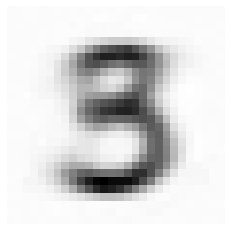

In [19]:
morph(model=auto_encoder.model,
      inputs=np.random.randint(0, len(train_dataset), 30),
      steps=20,
      delay=30)


Visualizing points with scatter

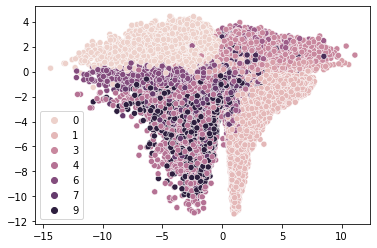

In [17]:

train_dataloader = MNISTDataloader(batch_size=config['batch_size'])

encodings, labels = [], []
for x, y in train_dataloader.train_dataloader():
    with torch.no_grad():
        output = auto_encoder.model.encoder(x)

    encodings.append(output)
    labels.append(y.view(-1))

encodings = torch.vstack(encodings).numpy()
labels = torch.vstack(labels).numpy()

sns.scatterplot(x=encodings[:, 0], y=encodings[:, 1], hue=labels.reshape(-1))
plt.show()